# Documentation: best_autodiff
# Introduction

Our package **best_autodiff** implements the forward and reverse modes of Automatic Differentiation (AD), solving the problem on how to estimate a function’s derivatives. While symbolic or numerical differentiation might be costly and produces unstable results, AD is both accurate to machine precision and computationally efficient. By breaking down the original function into a sequence of basic operations and applying the chain rule, AD accomplishes to outperform other classic techniques such as symbolic and numerical differentiation. Its relevance stems from the fact that derivatives are a fundamental calculus tool, widely used in a broad range of fields in science and engineering, and placed at the core of machine learning applications. For example, in deep learning, training and testing a neural network involves calculating a large quantity of gradients tens of thousands of times. For efficiency and accuracy, the forward and backpropagation methods for training/testing a neural network can make use of the forward and reverse modes of AD. 

# Background

## Introduction
*Automatic Differentiation (AD)* is a method for calculating the derivative of a function $f(x)$ specified by a computer program. Any function can be broken down into a sequence of elementary operations, where each operation results in an intermediate value $v_i$ with i being the $i^{th}$ operation. We can represent this with a graph where each intermediate value corresponds to node.  An example of such a graph, called a *computational (forward) graph*, is given below:

**Example** <br>
Computational forward graph for $f(x) = sin(4x)$
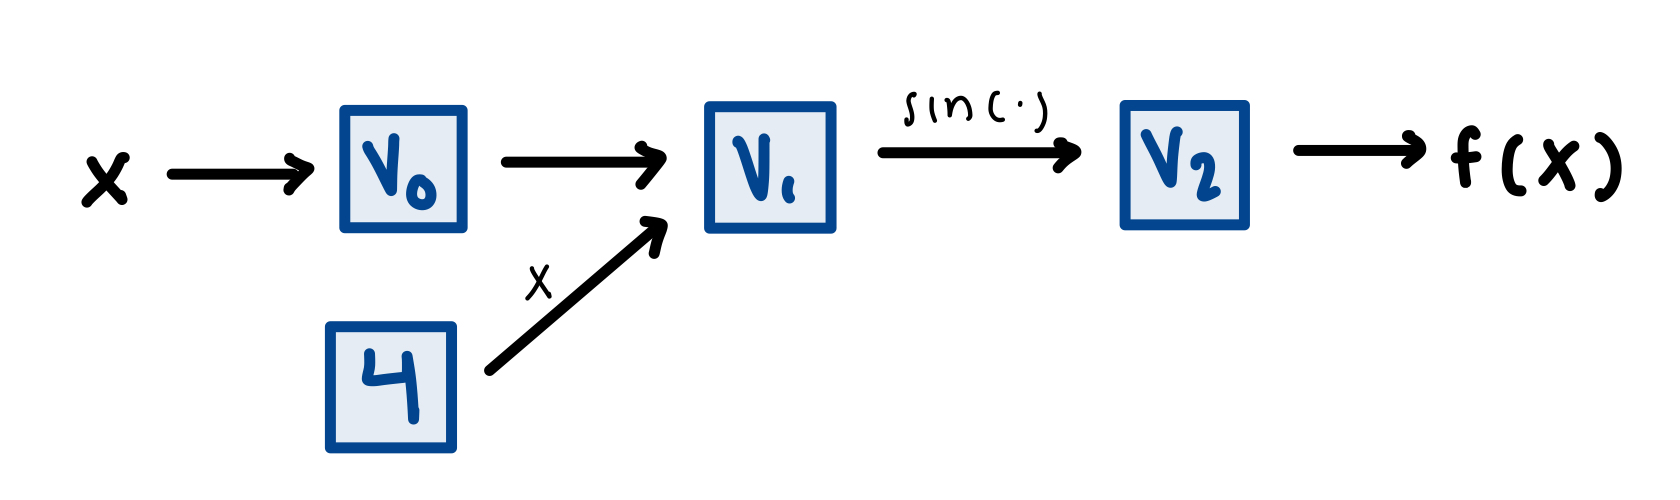

We can then repeatedly apply the *chain rule* to each elementary operation to compute derivatives. 

An example of the chain rule for a simple function is given below:
<br>

**Example** <br>
$\frac{dy}{dx}f(x) = sin(4x)$
- $\frac{dy}{dx}f(x) = \frac{dy}{du}sin(4x) * \frac{du}{dx}4x$
- $\frac{dy}{dx}f(x) = cos(4x)4$
<br>

Our package implements the forward and reverse modes of AD. This includes the implementation of dual numbers.

## Forward Mode
During forward mode, we compute the evaluation or *forward primal trace* of a function.

**Example**
<br>Evaluation/forward trace of $f(x) = sin(4x)$ at $x = \frac{\pi}{4}$
<br>

|Intermediate Value|Operation| Numerical Value | 
| :-- |:--|:--|
|$v_0$              | $\frac{\pi}{4}$| 0.78539816339 |
|$v_1$              | $4v_0$ | 3.14159265359 |
|$v_2 = f(x)$       | $sin(v_1)$| 0 |


At the same time it evaluates each intermediate variable $v_i$, *forward mode* also carries forward the directional derivative of each $v_i$ in a specified direction of our choosing, $p \in R^m$ (this process is called *forward tangent trace*). Because we are taking the derivatives with respect to a specific direction, we can define the *directional gradient* as $D_py_i = \sum_{j = 1}^{m}\frac{dy_i}{dx_j}p_j$. This is the projection of the gradient in the direction of the vector $p$. Once we choose our direction $p$, we calculate $D_pv_i$ for each intermediate $v_i$ (note: the $y_i$ in the $D_py_i$ definition correspond to our $v_i$s). This process is called the *forward tangent trace*. We can combine what we did previously with the *forward primal trace* with the *forward tangent trace* to get the *forward mode* of AD.

**Example**
AD for $f(x) = sin(4x)$ at $x = \frac{\pi}{4}$ <br>

First we need to choose a $p$. In this example our input is 1D, therefore, p = 1 is the logical choice for our direction. Thus we get $D_py_i = \frac{dy_i}{dx_i}$ where $y_i$ are the intermediate variables $v_i$. Next, we compute the *forward primal trace* and the *forward tangent trace* simultaneously.

|Forward Primal Trace|Forward Tangent Trace| Numerical Value of $v_i$; $D_pv_i$| 
|:--|:--|:--|
|$v_0 = \frac{\pi}{4}$|$D_pv_0 = 1$         |0.78539816339 ; 1  |          
|$v_1 = 4v_0$         |$D_pv_1 = 4D_pv_0$   |3.14159265359 ; 4 |          
|$v_2 = f(x) = sin(v_1)$|$D_pv_2 = cos(v_1)D_pv_1$|0 ; -4 |                        

The forward tangent trace value for the last row, is the derivative that we are looking for: $D_pv_2 = \frac{df}{dx}f(x)$ where x = $\frac{\pi}{4}$. Looking at how we compute the *forward tangent trace*, you can see the use of the chain rule.

Next, let's consider the higher dimensional case where our $f(x)$ is a vector function i.e. $f(x)$ maps inputs in the dimension $R^m$ to $R^n$. The gradient of a such a function is the Jacobian. Let's look at an example where m = 2 and n = 2. There are 2 possible directions: $p_1 = [1,0]^T$ and $p_2 = [0,1]^T$. If we take the direction gradient with the first direction $p_1$ we get the first column of the Jacobian and if we use $p_2$ we get the second column of the Jacobian. Therefore we can compute the Jacobian using m passes where each direction vector $p_i$ are set to the $m^{tg}$ unit vector along $x_m$ in the $m^{th}$ pass. 

In summary, forward mode AD works by: 
1. Breaking down a function into a sequence of elementary operations/functions
2. From the inside out, simultaneously compute:
    - The forward primal trace: evaluting our intermediate values.
    - The forward tangent trace: computing the derivatives of our intermediate values in a specified direction using the chain rule.

## Dual Numbers
In forward mode, we evaluate our intermediate values $v_j$ and their directional gradients $D_pv_j$ at the same time. We want to carry these two values together as a pair. We can do this using *dual numbers*. A dual number is a number $z = a + bϵ$ where $a$ corresponds to the "real part" and $b$ corresponds to the "dual part". $a$ and $b$ are real numbers while $ϵ$ has the property $ϵ^2=0$ and is not a real number. We can subsitute our function as the real part and the derivative of the function as the dual part. There are two key observations:
1. Adding such dual numbers is adding the real parts and adding the derivatives in the dual part
2. Multiplying such dual numbers is multiplying the real parts and applying the product rule for the derivatives in the dual part
3. The chain rule applies to dual numbers
In the forward node setting, we set the real parts of our dual numbers as the intermediate values $v_j$ and dual parts as $D_pv_j$.

## Reverse Mode
Unlike forward mode, reverse mode uses a two-pass process:

1. In the first pass (forward), we compute the primal trace $v_j$ and compute the partial derivatives $\frac{dv_j}{dv_i}$ where $v_i$ is the parent node (in the computational graph) of $v_j$.

2. In the second pass (reverse), we traverse the computational graph backwards and compute the partial derivative of the $i^{th}$ output $f_i$ with respect to the intermediate values (also called the *adjoint* of the intermediate value). We use this to compute $\sum_{j = child(i)}\frac{df}{dv_j}\frac{dvj}{dvi}$ where the first term in the summation is the adjoint of $v_j$.

We should highlight the properties of dual numbers do not work for reverse mode. Therefore, we have to implement another data structure (whose exact methods and features are still work in progress) for this case.

# How to Use

## PyPI Installation
Clients can import best_autodiff from [Test Python Package Index](https://test.pypi.org/) (PyPI). The package hasn't been uploaded there yet but will be for the final milestone.

In [ ]:
!python -m pip install -i https://test.pypi.org/simple/best_autodiff

## GitHub Installation
1. Go to the objective directory where you want to install best_autodiff.

2. Clone the repository. Using the command line you can type `git clone https://code.harvard.edu/CS107/team02.git`

3. Then position yourself into the project root using `cd team02`

4. Create a virtual environment where best_autodiff will run (recommended) `python3 -m venv /path/to/new/virtual/environment`

5. Activate virtual environment `source /path/to/new/virtual/environment/bin/activate`

6. Install `pip install -r requirements.txt`

7. Ready to go!

## Demo
To run forward mode, user must instantiate an object of the class Forward by passing in a differentiable function and a NumPy array of inputs to evaluate the function (and it's derivatives) at and then call the method for running forward mode. Finally, the user can extract the primal and tangent traces from the forward mode object.

<br>

An example of running forward mode for f = sin(2x + 4) at x = 3 using our package best_autodiff is given below. 

```python
# import packages
import numpy as np
import best_autodiff as ad 

# define function you want to differentiate
def f(x):
    return ad.sin(2*x + 4)

# define value you want to evaluate the function at (must be numPy array)
x = np.array([3])

# instantiate forward mode object with the specified function and input
forward = ad.Forward(f,x)

# run forward mode to compute the value and derivative of function evaluated at given x
forward.run_forward()

# the following code prints: value of function evaluated at given x
# -0.5440211108893698
print("primal trace:", forward.get_value())

# the following code prints: derivative of function evaluated at given x
# [-1.6781430581529049]
print("tangent trace:", forward.get_jacobian())
```

# Software Organization

## Tree-Structured Directory

best_autodiff will be structured as follows:

```
team02
└─── README.md
└─── LICENSE
└─── requirements.txt 
└─── pyproject.toml
└─── setup.cfg
│
└───best_autodiff
│   └─── __init__.py
│   └─── forward.py
│   └─── dualnumber.py
|   └─── functions.py
|   └─── reverse.py
│   └─── graph.py
│   └─── ...
│
└───docs
|   └─── documentation.ipynb
│   └─── milestone1.ipynb
|   └─── milestone2_progress.md
|   └─── milestone2.ipynb
│
└───tests
    └─── test_forward.py
    └─── test_dualnumber.py
    └─── test_reverse.py
    └─── test_graph.py
    └─── run_tests.sh
    └─── check_coverage.sh

```

## Modules

Our package plans to implement 5 different modules:
1. ```forward.py``` implements the forward mode of AD.
2. ```reverse.py``` will implement the reverse mode of AD.
3. ```dualnumber.py``` implements the dual number data structure. This class will have overloaded operations (i.e. addition, subtraction, multiplication, division) 
4. ```functions.py``` implements elementary functions for the dual number data structure, such as sin, cos, tan, exp, log, etc., and will be used in forward mode.
5. ```graph.py``` will implements the computational graph used in the forward and backward passes of reverse mode. 

## Test Suite

A test directory is available, containing a collection of modules with test cases for each module in the source code. Currently, we have a test suite for the three modules implemented so far: ```forward```, ```dualnumber```, and ```functions```. We use the ```pytest``` package for our tests.

## Package Distribution

Our package will be distributed through PyPI with PEP517.

# Implementation

## Classes
We plan on having the following classes:
1. Forward
2. Reverse
3. DualNumber
4. Graph

## Data Structures
We plan to have the following major data structures:
1. DualNumber: used in the forward mode of AD
2. Graph: used to implement the computational graph for reverse mode of AD
3. NumPy Arrays: used to represent our inputs and outputs (i.e. the jacobian)

## Class Method and Name Attributes 
### Forward
A list of class attributes and methods as well as code is given in the forward mode implementation below:

```python
class Forward:
	"""
	Class used to implement Forward mode of Automatic Differentiation for the following cases:
	1. Scalar function - Implemented
	2. Vector function - Implemented
	3. Multiple Functions - Not Implemented
	Attributes
	----------
	f:
		1D numPy array of functions to evaluate (currently 1 value)
	n_vars:
		numPy array of the number of inputs to each function in f (currently scalar)
	trace:
		list of dual numbers (real part = primal trace, dual part = tangent trace) representing current trace of forward mode
	Methods
	-------
	__init__(self, f, vals):
		instantiate forward mode object
	run_forward(self):
		carry out forward mode - compute the primal and tangent traces
	get_value(self):
		return the primal trace
	get_jacobian(self):
		return the tangent trace
	Examples
	--------
	1. SCALAR CASE: Forward mode results for f(x) = 2*x + 4 at x = 3
		def f(x):
			return 2*x + 4
		x = np.array([3])
		forward= Forward(f,x)
		forward.run_forward()
		print("primal trace:", forward.get_value())
		>> primal trace: 10
		print("tangent trace:", forward.get_jacobian())
		>> tangent trace: [2]
	2. VECTOR CASE: Forward mode results for f(x1, x2) = x1**2 + x2**2 at x1 = 2, x2 = 3
		def f(x):
			return x[0]**2 + x[1]**2
		x = np.array([2,3])
		forward= Forward(f, x)
		forward.run_forward()
		print("primal trace:", forward.get_value())
		>> primal trace: 13
		print("tangent trace:", forward.get_jacobian())
		>> tangent trace: [4.0, 6.0]
	3. MULTIPLE FUNCTIONS: NOT IMPLEMENTED YET
	"""
  
	def __init__(self, f, vals):
		"""
		Instantiates forward mode object
		Parameters
		----------
		f: 
			1D numPy array of functions to evaluate (currently 1 function)
		vals:
			numPy array of values to evaluate each function at

		Raises
		-------
		TypeError if [vals] is not of type np.ndarray
		TypeError if [f] is not callable (i.e a function)
		"""

		if not isinstance(vals, np.ndarray):
			raise TypeError(f"argument {vals} must be of type numpy.ndarray")
		if not callable(f):
			raise TypeError(f"argument {f} must be callable")
		self.f = f
		self.n_vars = len(vals)

		#create dual numbers for each input
		trace = []
		for v in vals:
			trace.append(dual.DualNumber(v, 1))
		self.trace = trace
  
  
	def run_forward(self):
		"""
		Calculates forward primal trace and forward tangent trace for each function in f (currently only one function) and stores it in self.trace
		"""
		
		#scalar function
		if self.n_vars == 1:
			self.trace[0] = self.f(self.trace[0])

		#vector function
		else:
			val = self.f(self.trace).real
			trace = []
			for i in range(self.n_vars):
				temp = self.trace[i]
				p = [dual.DualNumber(0,0)]*self.n_vars
				p[i] = temp
				dp = self.f(p).dual
				new = dual.DualNumber(val, dp)
				trace.append(new)
			self.trace = trace
  
	def get_value(self):
		"""
		Return the primal trace of forward mode (i.e. function self.f evaluated at the specified values)
		Returns
		-------
		primal:
			scalar representing the value of self.f evaluated at the inital input values in self.trace
		"""

		primal = self.trace[0].real
		return primal

	def get_jacobian(self):
		"""
		Return the tangent trace of forward mode
		Returns
		-------
		tangent:
			gradient of self.f evaluated at the intial input values in self.trace
			ex: [4.0, 6.0] where 4.0 = df/x1 and 6.0 = df/x2
		"""

		tangent = [v.dual for v in self.trace]
		return tangent
```
Currently our forward mode implementation can handle scalar functions and vector functions. Next we will implement handling multiple functions.

### Reverse - not yet implemented
|Name | Type | Description
------|------|------------
|values| name attribute |numpy array of values to evaluate specified function at
|dunder init| class method | instantiate reverse mode object given values
|evaluate | class method | compute first pass of reverse mode
|get_jacobian | class method | compute second pass of reverse mode

```python
# Preliminary outline (pseudo code) for the reverse class
class Reverse:
  """
  Parameters: values
  """
  def __init__(self, f):
        self.f = f

  @staticmethod
  def get_gradients(variable):
    """ Compute the first derivatives of `variable` 
    with respect to child variables.
    """
    gradients = defaultdict(lambda: 0)
        
		def compute_gradients(variable, path_value):
				for child_variable, local_gradient in variable.local_gradients:
						# "Multiply the edges of a path":
						value_of_path_to_child = path_value * local_gradient
						# "Add together the different paths":
						gradients[child_variable] += value_of_path_to_child
						# recurse through graph:
						compute_gradients(child_variable, value_of_path_to_child)
		
		compute_gradients(variable, path_value=1)
		# (path_value=1 is from `variable` differentiated w.r.t. itself)
		return gradients

# References
# https://sidsite.com/posts/autodiff/

```
### DualNumber
Our DualNumber Class supports operator overloading. We overload the basic elementary operations (i.e. addition, subtraction, multiplication, division) by using dunder methods (for example, \__add__). The outline of the Dual Number class is given below.

```python
class DualNumber:
	""" A class used to represent Dual Numbers 

	Attributes
	---------
	real: int, float, np.int32, np.int64 or np.float64
	    the real part of the dual number 

	dual: int, float, np.int32, np.int64 or np.float64
	    the dual part of the dual number

	Methods
	-------
	__add__(other)
	    Overloads + operator to support dual number addition with other dual numbers, floats and ints

	__radd__(other)
	    Overloads reflected + operator to support addition of dual numbers

	__mul__(other)
	    Overloads * operator to support dual number multiplication with other dual numbers, floats and ints

	__rmul__(other)
	    Overloads reflected * operator to support multiplication of dual numbers

	__sub__(other)
	    Overloads - operator to support dual number subtraction with other dual numbers, floats and ints

	__rsub__(other)
	    Overloads reflected - operator to support subtraction of dual numbers

	__truediv__(other)
		Overloads / operator to support dual number division with other dual numbers, floats and ints

	__rtruediv__(other)
	    Overloads reflected / operator to support dual number division

	__neg__()
	    Overloads - operator to support dual number negation

	__pow__(other)
	    Overloads ** operator to support exponentiation of dual numbers
	
	__rpow__(other)
	    Overloads reflexive ** operator to support reflexive exponentiation of dual numbers

	__rpow__()
	    Overloads reverse ** operator to support exponentiation to the power of dual numbers

	__eq__(z)
		Overloads == operator to support checking equality for dual numbers

	__str__()
		Returns string representation of dual numbers

	__repr__()
		Returns object representation of dual numbers in string format

	"""
```

Additionally, we implement methods for elementary functions (i.e. sin, cos, sqrt, log, exp, root, tan) inside the ```functions``` module. Our implementation consists of multiple methods (one for each mathematical function) and is outlined below.

```python
	""" 
	sqrt(z)
	Implements squared root of a DualNumber

	log(z, base)
	Implements log function of a DualNumber using any base

	root(z, n)
	Implements function to take the nth root of a dual number

	exp(z)
	Implements exponential function exp to the power of a DualNumber

	sin(z)
	Implements sine of a DualNumber

	cos(z)
	Implements cosine of a DualNumber

	tan(z)
	Implements tangent of a DualNumber
	"""
```

We will implement additional functions for the final milestone. These include, among others, arcsine, arccosine, arctangent, sinh, cosh and tanh.

### Graph - not yet implemented
Our graph class has 2 name attributes: value and children where value is the intermediate value of the current node and the children are a list of the intermediate values of the children node of the current node in the computational graph. A preliminary outline of the graph class is given below (we may add more functionality if needed).

```python
class Graph:
    def __init__(self, value):
        self.value = value
        self.children= []
```
## Other Libraries
We will use NumPy.


# Licensing

As one of the most liberal licenses, MIT license allows modification, distribution, copying and selling. Others can change the software however they wish for both commercial and private use. We will use the Numpy library and there is no patent included. For the class project, we would like our work to be permissive with little constraints, so MIT license is a good fit. 

# Future Features
## Reverse Mode
We would like to implement the reverse mode for automatic differentiation next. Our software will have the capability to compute derivatives using the reverse mode. To be more specific, we will have extra modules such as `graph.py`, `reverse.py` and the corresponding test files in our package. `reverse.py` will import the Graph class from `graph.py` to perform the computation. Unlike the forward mode, we will not use dual numbers for the reverse mode, so the primary challenge to implementing the forward and reverse passes will be to store and compute the computational graph by calculating local derivatives at every elementary operation. Our implementation will recursively traverse the computational graph and estimate local derivatives for each sub-node. In order to obtain the total derivative we will need to multiply the edges of each path, and then add each path’s result together. Similar to forward mode, we will need to overload the operations such as addition, subtraction, multiplication, sine, cosine, etc. 

## Changes to package organization
We have made two main changes:
- We decided to split the original `autodiff.py` module into 2 separate modules: `forward.py` and `reverse.py`. This decision was taken in order to make the testing implementation more straightforward and also allow the user to decide which differentiation mode will be needed on import. 
- Additionally, we decided to implement the mathematical functions for dual numbers outside of the ```dualnumber``` class. Therefore, these functions are all implemented inside the ```functions``` module (each class is implemented as a single function, and there is no class).